In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#change the directory to where you store the data.
dataDF=pd.read_csv('C:\\Users\\Administrator\\Documents\\Code\\博士论文\\2012_public_use_data_aug2016.csv',encoding='ISO-8859-1')

In [5]:
dataDF.head(5)

,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
0,1,2,4,26,1.0,2400,2,4,2,2,...,0.0,0.0,0.0,6186.0,NaN,NaN,NaN,NaN,NaN,1
1,2,3,5,23,1.0,114000,7,3,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,3,1,1,15,1.0,2550,2,4,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,3,7,2,1.0,660000,9,6,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,5,3,7,2,1.0,30000,5,3,6,2,...,0.0,0.0,0.0,22134.0,322542.0,0.0,45458.0,0.0,0.0,3


In [6]:
microdataDF=pd.read_csv('C:\\Users\\Administrator\\Documents\\Code\\博士论文\\2012microdata_codebook.csv',encoding='ISO-8859-1')

In [7]:
dataDF['YRCON']

0       1975
1       1985
2       1958
3       1983
4       1972
        ... 
6715    2005
6716    1979
6717     995
6718    1948
6719     995
Name: YRCON, Length: 6720, dtype: int64

In [4]:
dataDF['YRCON']=dataDF['YRCON'].replace(995,1946)

In [5]:
#fill Nan with 0 which means nonapplicable.
dataDF=dataDF.fillna(0)

In [6]:
#get EUI HEUI CEUI CN_HEUI...
dataDF['EUI']=(2.8*dataDF['ELBTU']+1.05*dataDF['NGBTU']+1.01*dataDF['FKBTU'])/dataDF['SQFT']
dataDF['HEUI']=(2.8*dataDF['ELHTBTU']+1.05*dataDF['NGHTBTU']+1.01*dataDF['FKHTBTU']+1.01*dataDF['DHHTBTU'])/(dataDF['SQFT'])
dataDF['CEUI']=(2.8*dataDF['ELCLBTU']+1.05*dataDF['NGCLBTU']+1.01*dataDF['FKCLBTU']+1.01*dataDF['DHCLBTU'])/dataDF['SQFT']
dataDF['CN_HEUI']=1000*dataDF['HEUI']/(dataDF['HDD65'])
dataDF['CN_CEUI']=1000*dataDF['CEUI']/(dataDF['CDD65'])

In [7]:
renew_dataDF=dataDF[dataDF['RENHVC']>0][dataDF['RENHVC']<2]

In [8]:
def building_rank(dataDF,building,EUI_list=['EUI','HEUI','CN_HEUI','CEUI','CN_CEUI']):
	"""
	Produce a radar plot of the level of energy efficiency.
	"""
	general_items={}
	m=dataDF.shape[0]

	dataDF_EUI=dataDF[EUI_list]
	dataDF_EUI=dataDF_EUI.dropna()
	EUI_rank_dict={}
	for EUI_label in EUI_list:
		if EUI_label in building.index:
			#EUI_dist(dataDF_EUI,label=EUI_label,building_EUI=building[EUI_label])
			dataDF_EUI=dataDF[EUI_label].values
			percentage_EUI=EUI_rank(dataDF_EUI,building_EUI=building[EUI_label])
			EUI_rank_dict[EUI_label]=percentage_EUI
	radar_plot(EUI_rank_dict,'EUI_ranks')
	plt.show()

In [9]:
from scipy import stats
def EUI_rank(dataDF_EUI,building_EUI=None):
    sorted_dataDF_EUI=np.sort(dataDF_EUI)
    percentage=stats.percentileofscore(list(sorted_dataDF_EUI),building_EUI)
    return percentage

In [10]:
def find_building_by_ID(dataDF,ID=None):
    """find a building in a database.
    Parameter
    ----------
    ID, the ID of the building.

    Return
    ----------
    building, a Building Object.
    """
    buildings=dataDF[dataDF['PUBID']>=ID][dataDF['PUBID']<=ID]
    if buildings.shape[0]>1:
        print('Multi-buildings are found. The first one is returned')
    elif buildings.shape[0]==0:
        building_series=pd.Series()
        print('Nothing found')
    else:
        building_series=buildings.iloc[0]
    return building_series

In [11]:
from math import pi
def radar_plot(data,title='Radar'):
	"""
	make a radar plot to demonstrate the energy efficiency of a building.
	"""
	Attributes =list(data.keys())
	AttNo = len(Attributes)
	values = list(data.values())
	values_100=[]
	for i in values:
		values_100.append(100)
	values += values [:1]
	angles = [n / float(AttNo) * 2 * pi for n in range(AttNo)]
	angles += angles [:1]
	values_100 += values_100 [:1]
	figureEUI=plt.figure()
	
	ax=figureEUI.add_subplot(2,2,1)
	ax = plt.subplot(111, polar=True)
	#Add the attribute labels to our axes
	plt.xticks(angles[:-1],Attributes)

	#Plot the line around the outside of the filled area, using the angles and values calculated before
	ax.plot(angles,values)
	ax.plot(angles,values_100,visible=False)
	for i in range(AttNo):
		text="%d"%((values[i]));x=angles[i];y=values[i]
		text=text+'%'
		ax.annotate(text,(x,y))
	ax.fill(angles, values, 'teal', alpha=0.1)

	#ax.set_title(title)
	figureEUI.savefig('Radar_20.jpg',api=300)
	plt.show()

In [12]:
#find similar buildings
dataDF=dataDF[dataDF['PBA']>=2][dataDF['PBA']<3]
dataDF=dataDF[dataDF['CDD65']>=2500][dataDF['CDD65']<5500]

In [44]:
dataDF[['PUBID','SQFT','PBA','CDD65','HDD65','MAINHT','MAINCL']]

,PUBID,SQFT,PBA,CDD65,HDD65,MAINHT,MAINCL
4,5,30000,2,4144,813,4.0,4.0
8,9,37500,2,2878,1341,2.0,2.0
21,22,2350,2,2680,1332,6.0,1.0
49,50,3800,2,3563,1366,2.0,1.0
90,91,3200,2,2744,942,2.0,1.0
166,167,5000,2,2578,2447,6.0,6.0
169,170,41000,2,4004,130,0.0,1.0
241,242,122000,2,3048,1216,2.0,3.0
281,282,15000,2,3641,1765,2.0,2.0
300,301,30000,2,4132,119,0.0,1.0


In [23]:
building=find_building_by_ID(dataDF,170)

In [24]:
building_dict={'features':building,'microdata':pd.Series(microdataDF['Values/Format codes'].values,index=microdataDF['Variable name'].values)}
building2=pd.DataFrame(building_dict)

In [25]:
for feature in ['PBA','REGION','RENELC','SQFT','CDD65','PUBCLIM','WLCNS','RFCNS','RENHVC',
                'WINTYP','GLSSPC','ELEVTR','FKCOOL','HEATP','RENINS','YRCONC','WKHRS','MAINHT','MAINCL','CEUI','CN_CEUI','EUI']:
    print(feature,building2.loc[feature]['features'],building2.loc[feature]['microdata'])

PBA 2.0 '01' = 'Vacant'
'02' = 'Office'
'04' = 'Laboratory'
'05' = 'Nonrefrigerated warehouse'
'06' = 'Food sales'
'07' = 'Public order and safety'
'08' = 'Outpatient health care'
'11' = 'Refrigerated warehouse'
'12' = 'Religious worship'
'13' = 'Public assembly'
'14' = 'Education'
'15' = 'Food service'
'16' = 'Inpatient health care'
'17' = 'Nursing'
'18' = 'Lodging'
'23' = 'Strip shopping mall'
'24' = 'Enclosed mall'
'25' = 'Retail other than mall'
'26' = 'Service'
'91' = 'Other'
REGION 3.0 '1' = 'Northeast'
'2' = 'Midwest'
'3' = 'South'
'4' = 'West'
RENELC 2.0 '1' = 'Yes'
'2' = 'No'
Missing = Not applicable
SQFT 41000.0 1,001 - 1,500,000
CDD65 4004.0 nan
PUBCLIM 3.0 1' = 'Very cold/Cold'
'2 '= 'Mixed-humid'
'3' = 'Hot-dry/Mixed-dry/Hot-humid'
'5' = 'Marine'
'7' = 'Withheld to protect confidentiality'
WLCNS 2.0 '1' = 'Brick, stone, or stucco'
'2' = 'Pre-cast concrete panels'
'3' = 'Concrete block or poured concrete (above grade)'
'4' = 'Aluminum, asbestos, plastic, or wood materials (

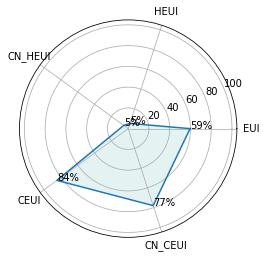

In [26]:
building_rank(dataDF,building)

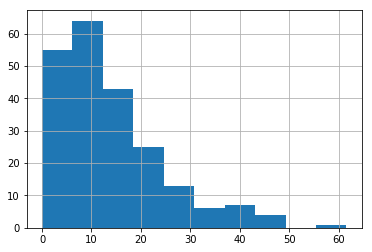

In [27]:
dataDF['CN_CEUI'].hist()

In [28]:
##### similar buildings
similar_dataDF=dataDF[dataDF['PBA']>1][dataDF['PBA']<3]
similar_dataDF=similar_dataDF[similar_dataDF['CDD65']>3000][similar_dataDF['CDD65']<5000]

In [29]:
similar_dataDF.shape

(160, 1124)

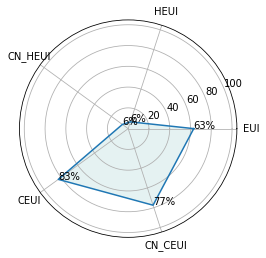

In [30]:
building_rank(similar_dataDF,building)